# Forecasting with Seasonal ARIMA
This notebook contains time series preparation, grid search for ARIMA parameters, model fitting, model evaluation, forecasting and an accuracy metric

In [ ]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# constants

# path to dataset
PATH_CLEANED = 'data/data.pckl'

# use this path for testing purpose (sine function with noise)
#PATH_CLEANED = 'data/sine.pckl'

# time span
SPLIT = datetime(2010, 1, 1)
END = datetime(2010, 12, 1)

# frequency and period length
PERIOD = 'W'
PERIOD_LEN = 52

### Loading and Preprocessing
Load and resample

In [3]:
# load dataset
data = pd.read_pickle(PATH_CLEANED)

In [4]:
# resample time series
ts = data['Global_active_power']
ts = ts.resample(PERIOD).mean()
ts.head()

Datetime
2006-12-17    2.505248
2006-12-24    1.734186
2006-12-31    1.958376
2007-01-07    1.484233
2007-01-14    1.604954
Freq: W-SUN, Name: Global_active_power, dtype: float64

Remove NaN values

In [5]:
# fill missing values with previous data
ts = ts.fillna(method='ffill')

### Grid Search for SARIMA Parameters
Run an auto arima function (similar to the R forecast::auto_arima), to determine the model with the lowest AIC

In [6]:
# analogous to R forecast::auto_arima
best_fit = auto_arima(ts[ts.index < SPLIT], seasonal=True, m=PERIOD_LEN)

C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal 

### Fit ARIMA model
Fit the ARIMA model with the best parameters and evaluate the model

In [7]:
# use best_fit model or set parameters manually instead

#order = best_fit.order
#seasonal_order = best_fit.seasonal_order
order = (0, 0, 0)
seasonal_order = (0, 1, 0, 53)


model = SARIMAX(ts[ts.index < SPLIT], order=order, seasonal_order=seasonal_order)
fit = model.fit()
print(fit.summary())

                                SARIMAX Results                                 
Dep. Variable:      Global_active_power   No. Observations:                  159
Model:             SARIMAX(0, 1, 0, 53)   Log Likelihood                 -20.335
Date:                  Wed, 22 Jul 2020   AIC                             42.670
Time:                          15:07:46   BIC                             45.334
Sample:                      12-17-2006   HQIC                            43.750
                           - 12-27-2009                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0859      0.009      9.380      0.000       0.068       0.104
Ljung-Box (Q):                       36.53   Jarque-Bera (JB):                 9.00
Prob(Q):                       

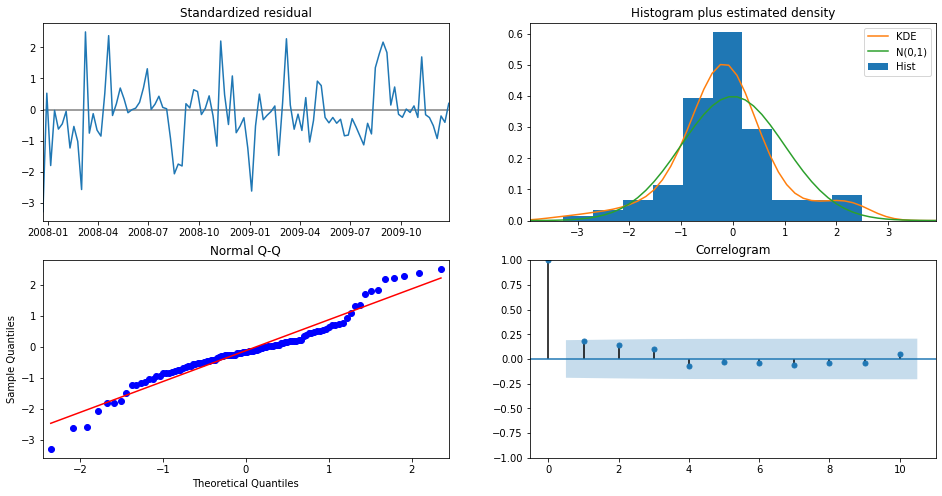

In [8]:
# check model adequacy
fit.plot_diagnostics(figsize=(16, 8))
plt.show()

### Forecast
Predict future values, calculate confidence intervals and evaluate the accuracy with the RMSE

In [9]:
pred = fit.get_prediction(start=ts.index.min() + pd.Timedelta(53*7, 'D'), end=END, dynamic=False)
pred_ci = pred.conf_int()

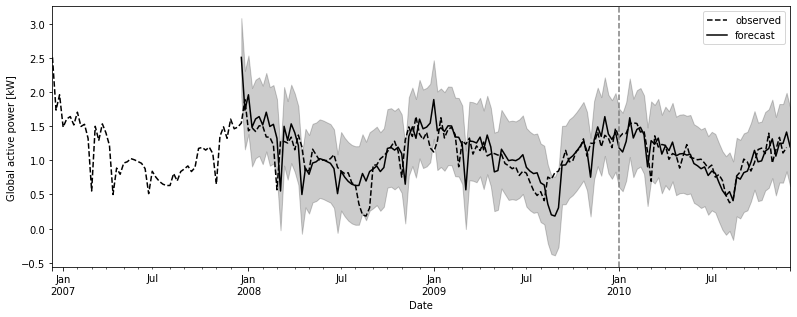

In [10]:
plt.figure(figsize=(13.22, 4.8))
ax = ts.plot(label='observed', c='k', linestyle='--')
pred.predicted_mean.plot(ax=ax, label='forecast', c='k')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Global active power [kW]')
#ax.set_ylim(-1)
plt.axvline(x=SPLIT, color='k', linestyle='--', c='gray')
plt.legend()
plt.show()

### Evaluation Metrics

In [11]:
# calulate RMSE
rmse = np.sqrt(((ts[(ts.index >= SPLIT) & (ts.index < END)] - pred.predicted_mean)**2).mean())
rmse

0.16545535892950264

In [12]:
# calculate MAPE
mape = np.mean(np.abs((ts[(ts.index >= SPLIT) & (ts.index < END)] - pred.predicted_mean) / ts[(ts.index >= SPLIT) & (ts.index < END)])) * 100
mape

13.435199131323639

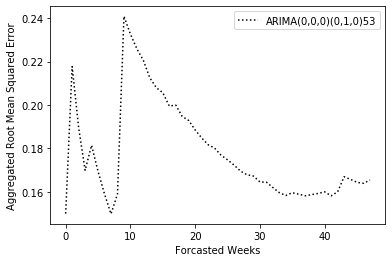

In [13]:
# error development
time_range = pd.date_range(start=SPLIT, end=END, freq=PERIOD)
rmse = []
for t in time_range:
    rmse.append(np.sqrt(((ts[(ts.index >= SPLIT) & (ts.index <= t)] - pred.predicted_mean[pred.predicted_mean.index <= t])**2).mean()))
plt.plot(np.arange(0, len(rmse)), rmse, c='k', linestyle=':', label='ARIMA(0,0,0)(0,1,0)53')
plt.legend()
plt.ylabel('Aggregated Root Mean Squared Error')
plt.xlabel('Forcasted Weeks')
plt.show()